In [1]:
%load_ext autoreload
%autoreload 2

# Rx Fire Policy replication plots

In this notebook we generate the main plot of our simulations results and some supplementary figures explaining the simulation process: 
 - Fig 4: Main results from simulation: cost-benefit ratio
 - Sup 7: Severity-Emissions response function
 - Sup 6: Descriptives of simulation process.

In [3]:
import os

import duckdb
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from prescribed.estimate.simulations import (
    calculate_benefits,
    make_model,
)
from prescribed.plot import template_plots

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42


# Set the font to be serif, rather than sans
plt.rcParams["font.family"] = "Helvetica Neue"

# Set the font size to be 12
plt.rcParams["font.size"] = 12

# Path for data
data_path = "/mnt/sherlock/oak/prescribed_data/"
sim_path = "/mnt/sherlock/oak/prescribed_data/processed/simulations"

How can we translate the policy in acres to our model parameters? We have to define the size of the treatments and the number of them to know how many 1 sq-km grids we need 

In [4]:
policy_size = 1_000_000
size_rx = 1_000

print(f"Number of policy 1 sq-km pixels: {policy_size / 247.105}")
print(
    f"If all fires are of {size_rx} acres, then the size is: {size_rx / 247.105} sq-km"
)
print(f"Number of fires in the policy area: {policy_size / size_rx}")

Number of policy 1 sq-km pixels: 4046.8626697153036
If all fires are of 1000 acres, then the size is: 4.046862669715304 sq-km
Number of fires in the policy area: 1000.0


In [5]:
# Load DNBR data and save to parquet to make it nicer for DuckDB
dnbr = pd.read_feather(
    os.path.join(data_path, "processed/dnbr_gee_inmediate/dnbr_long.feather")
).drop(columns=["spatial_ref"], errors="ignore")

dnbr["dnbr"] = np.where(dnbr.dnbr < 0, 0, dnbr.dnbr)

# Load MTBS dataset to add year to the DNBR data
mtbs = (
    gpd.read_file(
        os.path.join(
            data_path, "geoms/mtbs_perims_DD_updated/mtbs_perims_DD.shp"
        )
    )
    .to_crs("EPSG:3310")
    .drop(columns=["spatial_ref"], errors="ignore")
)

# Merge it to get years
mtbs["year"] = mtbs.Ig_Date.dt.year

dnbr = dnbr.merge(
    mtbs[["Event_ID", "year"]],
    right_on="Event_ID",
    left_on="event_id",
    how="left",
)
dnbr.drop(columns=["Event_ID"], inplace=True)

# Subset and save to parquet to make it nicer for DuckDB.
# Here we bottom code dnbr to avoid weird and large negative values
# dnbr["dnbr"] = np.where(dnbr.dnbr < 0, 0, dnbr.dnbr)

# Because of some dnbr issues (buffered data), we need to remove some of the data
# by using the templates we have from MTBS (remove grids in the buffer). We could
# normally do this by a spatial join, but we have a lot of data and it's slow.
treatments = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/treatments_mtbs.feather"
).drop(columns=["spatial_ref"], errors="ignore")

treatments_dnbr = treatments.merge(
    dnbr[["year", "dnbr", "lat", "lon", "grid_id"]],
    left_on=["lat", "lon", "year"],
    right_on=["lat", "lon", "year"],
    how="left",
)

# Clean treatments to only be in Event ID in California and have data
treatments_dnbr = treatments_dnbr[
    (treatments_dnbr.Event_ID.str.startswith("CA"))
    & (~treatments_dnbr.dnbr.isna())
]

# Add land type data
land_type = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/land_type/land_type.feather"
)
treatments_dnbr = treatments_dnbr.merge(
    land_type[["grid_id", "land_type"]], on="grid_id"
)

# Clean repeated observations for the same fire
treatments_dnbr_clean = treatments_dnbr.groupby(
    ["year", "Event_ID", "Incid_Name", "grid_id", "Ig_Date", "Incid_Type"],
    as_index=False,
).dnbr.max()

treatments_dnbr_clean.to_parquet("../data/dnbr.parquet")

### Calculate fire probabilities

In [5]:
wildfires_list = mtbs[
    (mtbs.Event_ID.str.startswith("CA"))
    & (mtbs.Incid_Type == "Wildfire")
    & (mtbs.Ig_Date.dt.year >= 2010)
].Event_ID.tolist()

treatments["year"] = treatments.Ig_Date.dt.year

probs = (
    treatments[treatments.Event_ID.isin(wildfires_list)].groupby("year").size()
    / 103475
).reset_index()
probs.rename(columns={0: "fire"}, inplace=True)

probs["num_fires"] = (
    mtbs[mtbs.Event_ID.isin(wildfires_list)].groupby("year").size().values
)

probs.to_csv("../data/results/probability_conifer_fire.csv", index=False)

In [ ]:
probs = (
    treatments[treatments.Ig_Date.dt.year > 2010]
    .groupby(treatments.Ig_Date.dt.year, as_index=False)
    .size()
)

probs["fire"] = probs["size"] / 103475
probs.rename(columns={"Ig_Date": "year"}, inplace=True)
probs.to_csv("../data/results/probability_conifer_fire.csv", index=False)

### Calculate average severity for Rx fire and average observed severity

In [ ]:
wildfires_list = mtbs[
    (mtbs.Event_ID.str.startswith("CA"))
    & (mtbs.Incid_Type == "Prescribed Fire")
].Event_ID.tolist()

dnbr[
    (dnbr.event_id.isin(wildfires_list))
    & (dnbr.grid_id.isin(land_type[land_type.land_type == 2].grid_id.tolist()))
].dnbr.mean()

62.806675

In [ ]:
wildfires_list = mtbs[
    (mtbs.Event_ID.str.startswith("CA"))
    & (mtbs.Incid_Type == "Wildfire")
    & (mtbs.Ig_Date.dt.year >= 2010)
].Event_ID.tolist()

dnbr[(dnbr.event_id.isin(wildfires_list))].groupby(
    "year", as_index=False
).dnbr.mean().to_csv("../data/results/dnbr_values_year.csv", index=False)

### Distribution of severity of low-severity vs. prescribed

/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(*plot_args, **plot_kwargs)
/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(*plot_args, **plot_kwargs)
/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(*plot_args, **plot_kwargs)
/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(*plot

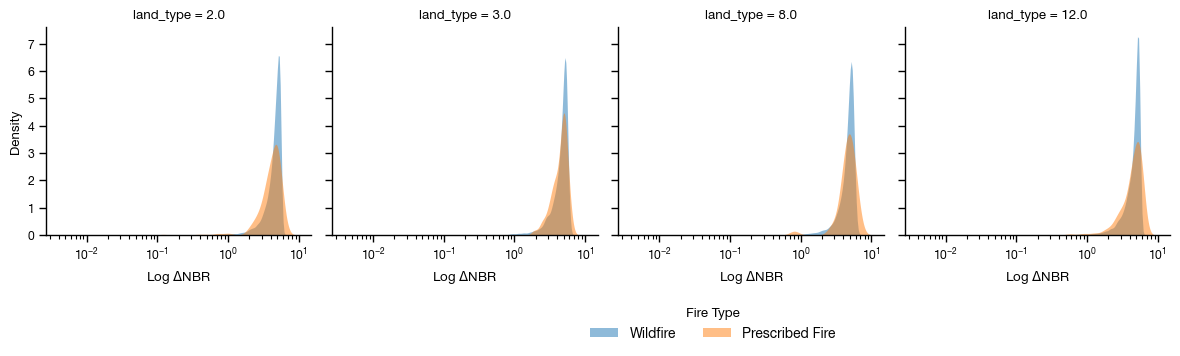

In [ ]:
land_types = {
    2.0: "conifers",
    12.0: "shrublands",
    3.0: "conifer-hardwood",
    8.0: "hardwood",
}

plot_data = treatments_dnbr_clean.merge(
    land_type[["grid_id", "land_type"]], on="grid_id"
)

# Subset to get only conifers!
plot_data = plot_data[plot_data.land_type.isin(land_types.keys())]

plot_data = plot_data[
    plot_data.Event_ID.isin(
        mtbs[
            mtbs.Incid_Type.isin(["Prescribed Fire", "Wildfire"])
        ].Event_ID.tolist()
    )
]

# Filter all Wildifre observations whose dnbr is larger than 269
plot_data = plot_data[
    ~((plot_data.Incid_Type == "Wildfire") & (plot_data.dnbr > 269))
]
plot_data["log_dnbr"] = np.log(plot_data.dnbr)

sns.set_context("paper")
g = sns.FacetGrid(data=plot_data, col="land_type", hue="Incid_Type")

g.map(
    sns.kdeplot,
    "log_dnbr",
    fill=True,
    alpha=0.5,
    linewidth=0,
    log_scale=True,
    palette=["#FF7F0E", "#1F77B4"],
    common_norm=False,
    multiple="layer",
    hue_order=["Wildfire", "Prescribed Fire"],
)

# Add legend at the bottom of the plot
g.add_legend(
    title="Fire Type",
    bbox_to_anchor=(0.5, 0.0),
    loc="upper center",
    ncol=2,
    fontsize=10,
)
g.set_axis_labels(r"Log $\Delta$NBR", "Density")

# Save as a PDF
plt.savefig(
    "../figs/dnbr_rx_lowseverity.pdf",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)

In [ ]:
rx_fire_dnbr = dnbr[
    dnbr.event_id.isin(
        mtbs[mtbs.Incid_Type == "Prescribed Fire"].Event_ID.tolist()
    )
].dnbr.mean()
rx_fire_dnbr

87.75124

## Sup Fig 7: Explore $\Delta$ NBR relationship with PM $_{2.5}$ concentrations

Degree 1: RMSE = 19794.3644, R2 = 0.4574
Degree 2: RMSE = 20796.3793, R2 = 0.4011
Degree 3: RMSE = 20942.1878, R2 = 0.3926
Degree 4: RMSE = 21221.8079, R2 = 0.3763
Degree 5: RMSE = 22127.5715, R2 = 0.3219
Degree 6: RMSE = 22511.6297, R2 = 0.2982
Degree 7: RMSE = 22382.1758, R2 = 0.3062
Degree 8: RMSE = 21908.4480, R2 = 0.3353


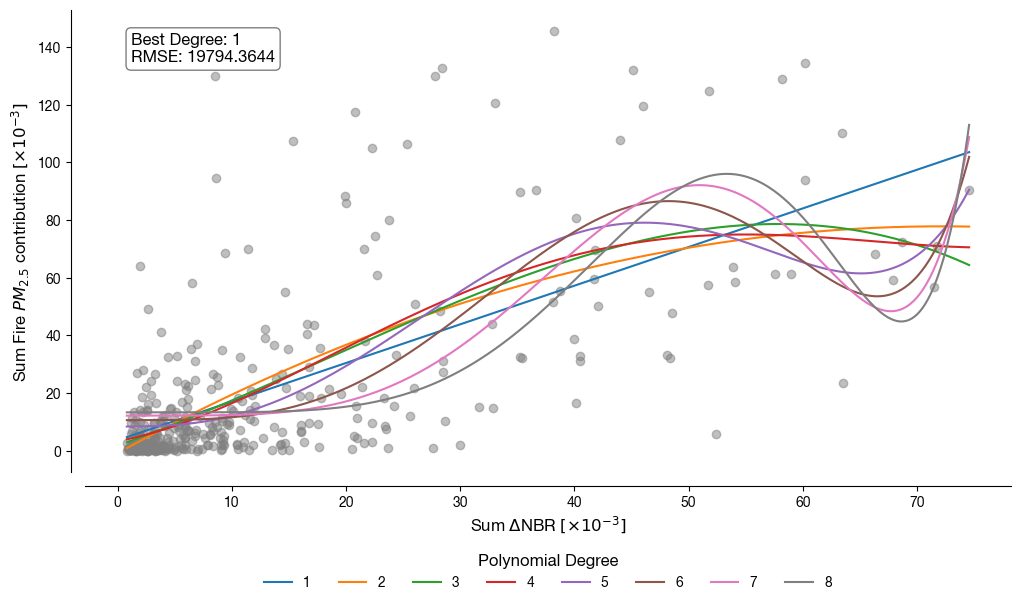

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures


def find_best_polynomial_fit(
    data,
    x_col,
    y_col,
    degrees=range(1, 9),
    test_size=0.2,
    random_state=42,
    remove_outliers=False,
    quantile_range=(0.025, 0.975),
):
    """
    Finds the best polynomial fit between two columns in a DataFrame using RMSE.

    Parameters
    ----------
    data : pd.DataFrame
        The input DataFrame containing the data.
    x_col : str
        The name of the column to use as the independent variable.
    y_col : str
        The name of the column to use as the dependent variable.
    degrees : range, optional
        The range of polynomial degrees to test, by default range(1, 9).
    test_size : float, optional
        The proportion of the data to use as the test set, by default 0.2.
    random_state : int, optional
        The random seed for reproducibility, by default 42.
    remove_outliers : bool, optional
        Whether to remove outliers from the data, by default False.
    quantile_range : tuple, optional
        The lower and upper quantiles to use for outlier removal, by default (0.025, 0.975).

    Returns
    -------
    None
    """
    # Optionally remove outliers
    if remove_outliers:
        lower_x, upper_x = data[x_col].quantile(quantile_range)
        lower_y, upper_y = data[y_col].quantile(quantile_range)
        data = data[
            (data[x_col] >= lower_x)
            & (data[x_col] <= upper_x)
            & (data[y_col] >= lower_y)
            & (data[y_col] <= upper_y)
        ]

    # Split the data into train and test sets
    X = data[[x_col]].values
    y = data[y_col].values
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Store RMSE values for each degree
    rmse_scores, r2_scores = [], []

    # Plot setup
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(X / 1000, y / 1000, color="gray", alpha=0.5)

    # Loop through polynomial degrees
    for degree in degrees:
        # Create polynomial features
        poly = PolynomialFeatures(degree=degree)
        X_train_poly = poly.fit_transform(X_train)
        X_test_poly = poly.transform(X_test)

        # Fit the model
        model = LinearRegression()
        model.fit(X_train_poly, y_train)

        # Predict on the test set
        y_pred = model.predict(X_test_poly)

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_scores.append((degree, rmse))

        # Calculate R-squared
        r2 = r2_score(y_test, y_pred)
        r2_scores.append((degree, r2))

        # Plot the fit
        X_plot = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)
        y_plot = model.predict(poly.transform(X_plot))
        ax.plot(X_plot / 1000, y_plot / 1000, label=f"{degree}")

    # Display RMSE scores
    for degree, rmse, r2 in zip(degrees, rmse_scores, r2_scores):
        print(f"Degree {degree}: RMSE = {rmse[1]:.4f}, R2 = {r2[1]:.4f}")

    # Add best RMSE and degree to the plot as text
    best_degree = min(rmse_scores, key=lambda x: x[1])[0]
    best_rmse = min(rmse_scores, key=lambda x: x[1])[1]
    ax.text(
        0.05,
        0.95,
        f"Best Degree: {best_degree}\nRMSE: {best_rmse:.4f}",
        transform=plt.gca().transAxes,
        fontsize=12,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.5),
    )

    # Move legend to the bottom of the plot outside the plotting area
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        ncol=len(degrees),
        fontsize=10,
        frameon=False,
        title="Polynomial Degree",
    )
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)

    template_plots(
        ax,
        xlab=r"Sum $\Delta$NBR $[\times 10^{-3}]$",
        ylab=r"Sum Fire $PM_{2.5}$ contribution $[\times 10^{-3}]$ ",
    )


smoke_linked = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/smoke_linking/severity_emissions_linked.feather"
)


# Assuming `smoke_linked` is your DataFrame
find_best_polynomial_fit(
    smoke_linked,
    x_col="sum_severity",
    y_col="sum_contrib",
    degrees=range(1, 9),
    remove_outliers=True,
    quantile_range=(0.025, 0.90),
)

# Save the plot as a PDF
plt.savefig(
    "../figs/smoke_linked_polynomial_fit.pdf",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)

In [6]:
smoke_linked = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/smoke_linking/severity_emissions_linked.feather"
)

# Change year type to avoid problems
smoke_linked["year"] = smoke_linked.year.astype(int)

coefs = make_model(
    smoke_linked,
    formula="sum_contrib ~ sum_severity + total_pixels + total_days | year",
    bootstrap=True,
    k=999,
)

# Estimate boostrap confidence intervals for marginal effects

# Range of severities
range_severity = np.arange(
    smoke_linked["sum_severity"].min(),
    smoke_linked["sum_severity"].max(),
    100,
)

# Multiply the second column of coef by the range of severities
boot_samples = []
for i in range(999):
    boot_samples.append(coefs[i, 0] * range_severity)

boots = np.vstack(boot_samples)
bounds = np.percentile(boots, [2.5, 0.5, 97.5], axis=0)

Bootstrapping model results/coefficients: 100%|██████████| 999/999 [00:35<00:00, 27.93it/s]


/tmp/ipykernel_3040192/179961673.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_fires["sample"] = "All Fires"
/tmp/ipykernel_3040192/179961673.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_fires["sample"] = "Matched Fires"


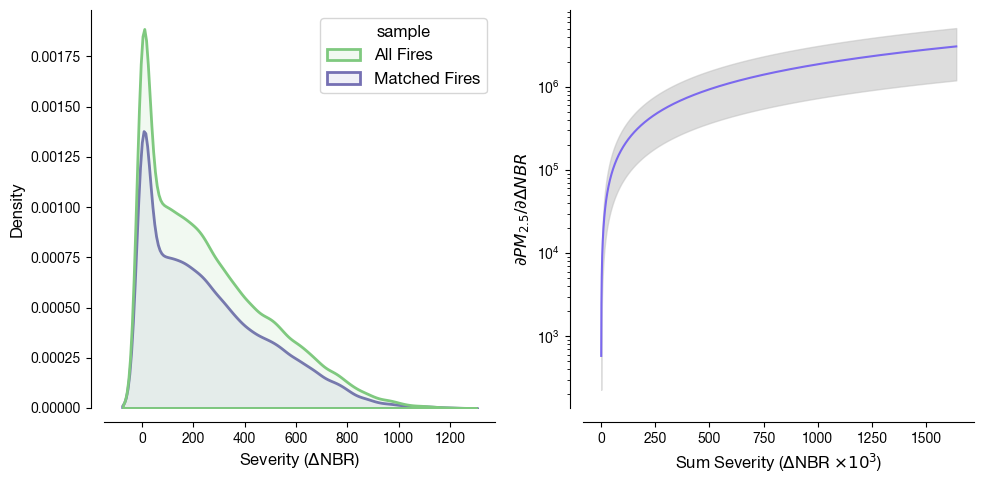

In [ ]:
# Plot the predictions
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Create a dataframe to plot the density of the dnbr values for all fires
# and the matched fires

all_fires = treatments_dnbr_clean[treatments_dnbr_clean.year > 2006]
all_fires["sample"] = "All Fires"

matched_fires = treatments_dnbr_clean[
    (treatments_dnbr_clean.year > 2006)
    & (treatments_dnbr_clean.Event_ID.isin(smoke_linked.event_id.tolist()))
]
matched_fires["sample"] = "Matched Fires"
data_dist = pd.concat([all_fires, matched_fires])


# treatments_dnbr_clean[treatments_dnbr_clean.year > 2006].dnbr.plot.density(
#     ax=ax[0], color="#7570b3", linewidth=2
# )
# treatments_dnbr_clean[
#     (treatments_dnbr_clean.year > 2006)
#     & (treatments_dnbr_clean.Event_ID.isin(smoke_linked.event_id.tolist()))
# ].dnbr.plot.density(ax=ax[0], color="#7fc97f", linewidth=2,)

sns.kdeplot(
    data=data_dist,
    x="dnbr",
    hue="sample",
    ax=ax[0],
    palette=["#7fc97f", "#7570b3"],
    common_norm=True,
    fill=True,
    linewidth=2,
    alpha=0.1,
)


# Apply template
template_plots(ax[0], xlab="Severity ($\Delta$NBR)", ylab="Density")

# # Add a legend for the two density lines
# ax[0].legend(["All Fires", "Matched Fires"], loc="upper right")

# Plot marginal effect of severity on emissions using log scale
ax[1].set_yscale("log")
ax[1].fill_between(
    range_severity / 1000,
    bounds[0],
    bounds[2],
    alpha=0.5,
    color="#bdbdbd",
)

# Plot median prediction as a line
ax[1].plot(
    range_severity / 1000,
    np.mean(boots, axis=0),
    color="mediumslateblue",
)

# Apply template
template_plots(
    ax[1],
    xlab="Sum Severity ($\Delta$NBR $\\times 10^{3} $)",
    ylab="$\partial PM_{2.5} / \partial \Delta NBR$",
)

plt.tight_layout()

# Save as a PDF
plt.savefig(
    "../figs/severity_emissions_link.pdf",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)


## Fig 4: Discounted benefit-cost ratio for two types of simulation (w/ and wo/ spillovers)

In [24]:
# Set seed numpy
np.random.seed(42)

# Load smoke link data
smoke_linked = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/smoke_linking/severity_emissions_linked.feather"
)

# Avoid prediction errors
smoke_linked["year"] = smoke_linked.year.astype(int)

benefits_no_spill, sims = calculate_benefits(
    n_treats=90,
    path=f"{sim_path}/policy_no_spill_4000_large_4000",
    # path="../data/policy_no_spill_4000/",
    discount_rates=[0.02, 0.04, 0.06, 0.1],
    treat_severity=100,
    average_treats=True,
    linked_data=smoke_linked,
    formula="sum_contrib ~ sum_severity + total_pixels + total_days | year",
    bootstrap=True,
    predict=True,
)
benefits_no_spill["treatment"] = "No Spill"

benefits_spill, sims = calculate_benefits(
    n_treats=90,
    path=f"{sim_path}/policy_spill_large_150",
    discount_rates=[0.02, 0.04, 0.06, 0.1],
    treat_severity=100,
    average_treats=True,
    linked_data=smoke_linked,
    formula="sum_contrib ~ sum_severity + total_pixels + total_days | year",
    bootstrap=True,
    predict=True,
)
benefits_spill["treatment"] = "Spillovers"

benefits = pd.concat([benefits_no_spill, benefits_spill])

Bootstrapping model results/coefficients: 100%|██████████| 999/999 [00:32<00:00, 30.46it/s]
/home/topcat/projects/extract/src/prescribed/estimate/simulations.py:461: UserWarning: 0.0611% of rows were removed
  warnings.warn(f"{prop:.4f}% of rows were removed")
Bootstrapping model results/coefficients: 100%|██████████| 999/999 [00:22<00:00, 44.46it/s]


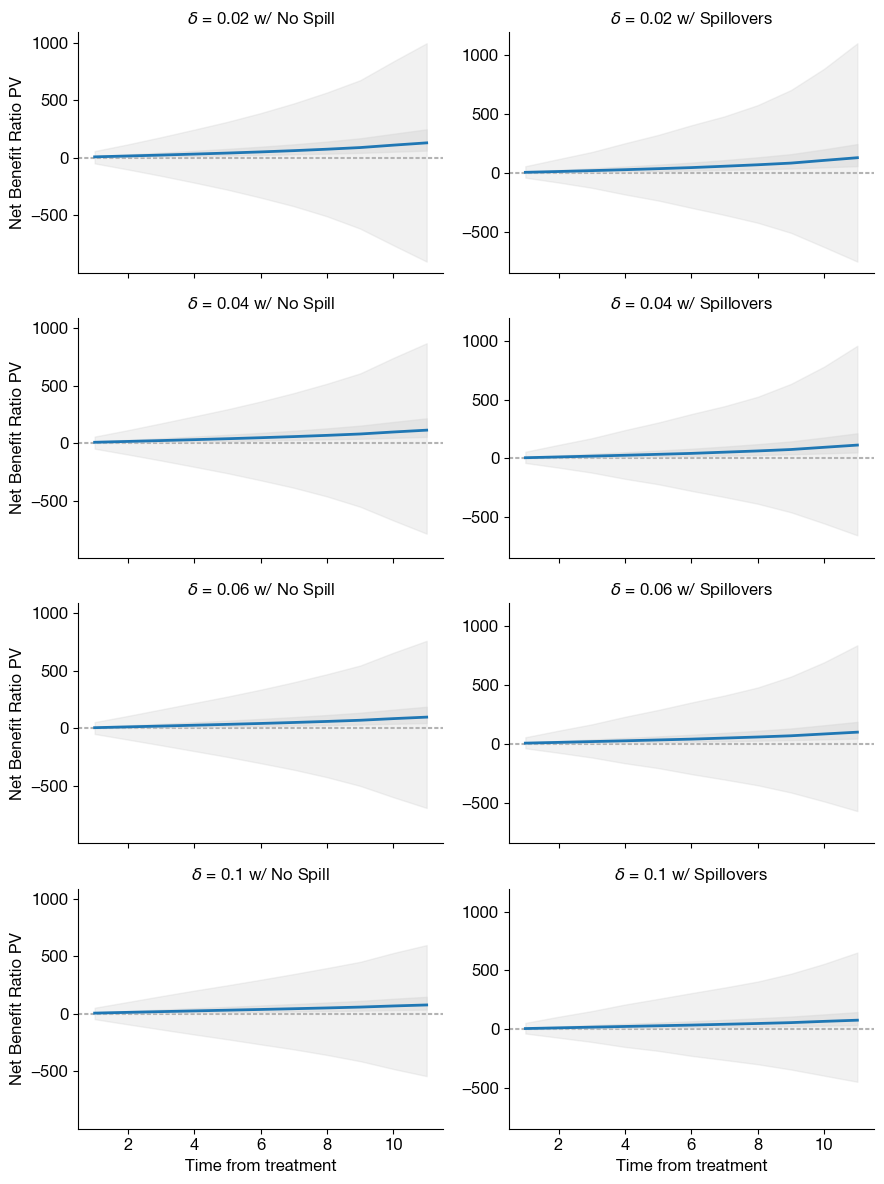

In [23]:
# remove weird ratios
benefits = benefits.dropna()

mean_benefits = (
    benefits.groupby(["lag", "discount_rate", "treatment"])
    .ratio.median()
    .reset_index()
)

g = sns.relplot(
    data=mean_benefits,
    x="lag",
    y="ratio",
    row="discount_rate",
    col="treatment",
    kind="line",
    height=3,
    aspect=1.5,
    linewidth=2,
    zorder=5,
    legend=False,
    facet_kws={"sharey": "col", "sharex": True},
)

(
    g.map(plt.axhline, y=1, color=".7", dashes=(2, 1), zorder=0)
    .set_axis_labels("Time from treatment", "Net Benefit Ratio PV")
    .set_titles(r"$\delta$ = {row_name} w/ {col_name}")
    .tight_layout(w_pad=0)
)

colors = sns.color_palette(
    "crest", n_colors=len(mean_benefits["discount_rate"].unique())
)

# Plot the 0.025 and 0.975 quantiles for each discount rate and lag
iqr = (
    benefits.groupby(["lag", "discount_rate", "treatment"])
    .ratio.quantile([0.25, 0.75])
    .unstack()
    .reset_index()
)

# Plot the 0.025 and 0.975 quantiles for each discount rate and lag
ci = (
    benefits.groupby(["lag", "discount_rate", "treatment"])
    .ratio.quantile([0.05, 0.95])
    .unstack()
    .reset_index()
)

stds = (
    benefits.groupby(["lag", "discount_rate", "treatment"])
    .ratio.std(ddof=2)
    .reset_index()
)

ci_alt = pd.DataFrame(
    {
        "ci_low": mean_benefits.ratio - 1.96 * stds.ratio / np.sqrt(988),
        "ci_high": mean_benefits.ratio + 1.96 * stds.ratio / np.sqrt(988),
        "lag": mean_benefits.lag,
        "discount_rate": mean_benefits.discount_rate,
        "treatment": mean_benefits.treatment,
    }
)

for idxs, ax in g.axes_dict.items():
    dr, treat = idxs
    # Get the quantiles
    q_dr = ci[(ci.discount_rate == dr) & (ci.treatment == treat)]
    q_dr_iqr = iqr[(iqr.discount_rate == dr) & (iqr.treatment == treat)]

    ax.fill_between(
        q_dr.lag,
        q_dr[0.05],
        q_dr[0.95],
        color="#bdbdbd",
        # color=colors[list(mean_benefits["discount_rate"].unique()).index(dr)],
        alpha=0.2,
    )

    ax.fill_between(
        q_dr.lag,
        q_dr_iqr[0.25],
        q_dr_iqr[0.75],
        color="#d9d9d9",
        alpha=0.5,
        # color=colors[list(mean_benefits["discount_rate"].unique()).index(dr)],
    )
    # plt.yscale("asinh", shift=10)
    # ax.set_yscale("log")


plt.tight_layout()

# # Save plot
# plt.savefig(
#     "../figs/pv_benefits_pe_avg.pdf",
#     bbox_inches="tight",
#     dpi=300,
#     transparent=True,
# )


In [ ]:
iqr[(iqr.treatment == "Spillovers") & (iqr.lag == 10)]

,lag,discount_rate,treatment,0.25,0.75
73,10,0.02,Spillovers,8.443834,17.567708
75,10,0.04,Spillovers,7.429135,15.541602
77,10,0.06,Spillovers,6.579752,13.807545
79,10,0.10,Spillovers,5.265719,10.988837


In [ ]:
ci[(ci.treatment == "Spillovers") & (ci.lag == 10)]

,lag,discount_rate,treatment,0.05,0.95
73,10,0.02,Spillovers,4.726011,29.120526
75,10,0.04,Spillovers,4.156384,25.659015
77,10,0.06,Spillovers,3.675746,22.825532
79,10,0.10,Spillovers,2.920794,18.196737


### Plot example of simulation fire event

In [ ]:
path = f"{sim_path}/policy_no_spill_4000_large_4000"
df = duckdb.query(f"""
WITH simulation_data AS (
    SELECT *
    FROM '{path}/*.parquet'
    where sim is not null
), 
dnbr_data AS (
select
        grid_id, 
        year, 
        Event_ID as event_id, 
        Incid_Name as event_name, 
        dnbr 
from '../data/dnbr.parquet' 
where year > 2010
), 
dnbr_event_agg as (
select event_id, 
    event_name,      
    year,
    sum(dnbr) as sum_dnbr
from dnbr_data
group by event_id, event_name, year
), 
benefits_grid_simulation as (
SELECT  s.grid_id, 
        s.year_treat, 
        s.year, 
        d.event_id, 
        d.event_name, 
        s.sim,
        s.coeff, 
        d.dnbr,
        case when (d.dnbr + s.coeff) < 0 
                then 0 
                else d.dnbr + s.coeff 
        end as sim_benefit
from simulation_data s 
inner join dnbr_data d
on s.grid_id = d.grid_id 
    and s.year = d.year
) select grid_id, year_treat, event_id, event_name, mean(sim_benefit) as mean_benefit
from benefits_grid_simulation
where event_id == 'CA3720111927220200905' and year
group by grid_id, year_treat, event_id, event_name
""").to_df()

grids_fire = treatments_dnbr[
    treatments_dnbr.Event_ID == "CA3720111927220200905"
][["grid_id", "lat", "lon"]]

df = df.merge(grids_fire, on="grid_id")

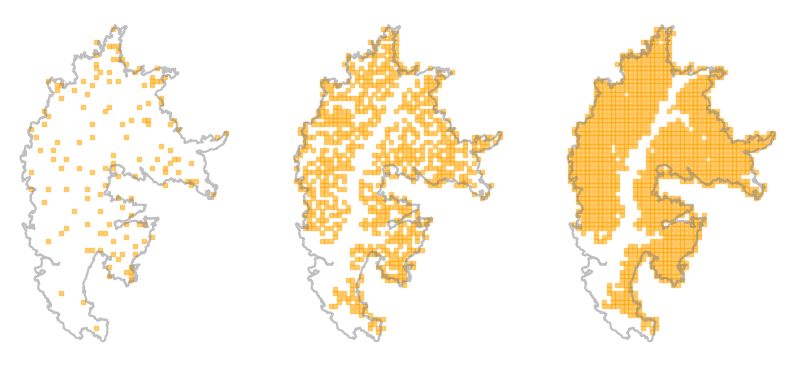

In [ ]:
# Total treats
treat_time = df.groupby(
    ["grid_id", "lat", "lon"], as_index=False
).year_treat.first()


years_plot = [2010, 2015, 2020]

# Plot each year in df as scatter
fig, ax = plt.subplots(1, len(years_plot), figsize=(10, 10))

for ax, year in zip(ax.flatten(), years_plot):
    data = treat_time[treat_time.year_treat <= year]
    ax.scatter(data.lon, data.lat, marker=",", s=5, c="orange", alpha=0.5)
    mtbs[mtbs.Event_ID == "CA3720111927220200905"].geometry.boundary.plot(
        ax=ax, color="gray", alpha=0.5
    )
    ax.axis("off")

# Save plot as PDF
plt.savefig(
    "../figs/treats_fire_creek.pdf",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)

In [ ]:
(treat_time.groupby("year_treat").grid_id.count().cumsum()) / 1772

year_treat
2010    0.080135
2011    0.161400
2012    0.239278
2013    0.308691
2014    0.388262
2015    0.467833
2016    0.544582
2017    0.628104
2018    0.694695
2019    0.764108
Name: grid_id, dtype: float64

In [ ]:
df_complete = treatments_dnbr[
    treatments_dnbr.Event_ID == "CA3720111927220200905"
][["grid_id", "dnbr", "lat", "lon"]].merge(
    df, on=["grid_id", "lat", "lon"], how="left"
)
df_complete["mean_benefit"] = df_complete.mean_benefit.fillna(df_complete.dnbr)

df_complete["pixel_benefit"] = df_complete.dnbr - df_complete.mean_benefit

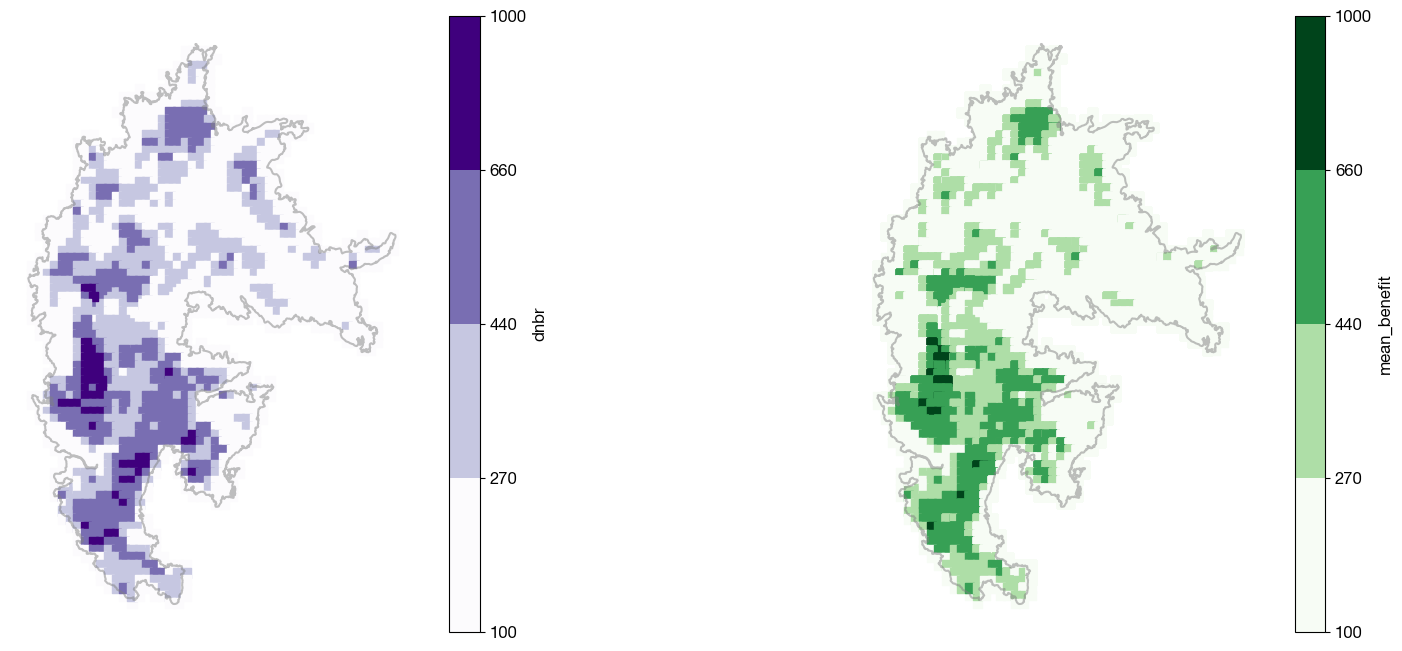

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Unify the colorbar for both plots
vmin = treatments_dnbr[
    treatments_dnbr.Event_ID == "CA3720111927220200905"
].dnbr.min()
vmax = treatments_dnbr[
    treatments_dnbr.Event_ID == "CA3720111927220200905"
].dnbr.max()

df_complete.plot(
    x="lon",
    y="lat",
    kind="scatter",
    c="mean_benefit",
    s=45,
    marker=",",
    ax=ax[1],
    cmap="Greens",
    norm=matplotlib.colors.BoundaryNorm(
        boundaries=[100, 270, 440, 660, 1000],
        ncolors=256,
    ),
)

mtbs[mtbs.Event_ID == "CA3720111927220200905"].geometry.boundary.plot(
    ax=ax[1], color="gray", alpha=0.5
)

treatments_dnbr[treatments_dnbr.Event_ID == "CA3720111927220200905"].plot(
    ax=ax[0],
    x="lon",
    y="lat",
    kind="scatter",
    c="dnbr",
    s=50,
    marker=",",
    cmap="Purples",
    colorbar=True,
    norm=matplotlib.colors.BoundaryNorm(
        boundaries=[100, 270, 440, 660, 1000],
        ncolors=256,
    ),
)

mtbs[mtbs.Event_ID == "CA3720111927220200905"].geometry.boundary.plot(
    ax=ax[0], color="gray", alpha=0.5
)

ax[0].axis("off")
ax[1].axis("off")

# Save plot as PDF
plt.savefig(
    "../figs/fire_creek_benefit.pdf",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)

In [ ]:
path = f"{sim_path}/policy_no_spill_4000_large_4000"
df = duckdb.query(f"""
WITH simulation_data AS (
    SELECT *
    FROM '{path}/*.parquet'
    where sim is not null
), 
dnbr_data AS (
select
        grid_id, 
        year, 
        Event_ID as event_id, 
        Incid_Name as event_name, 
        dnbr 
from '../data/dnbr.parquet' 
where year > 2010
), 
dnbr_event_agg as (
select event_id, 
    event_name,      
    year,
    sum(dnbr) as sum_dnbr
from dnbr_data
group by event_id, event_name, year
), 
benefits_grid_simulation as (
SELECT  s.grid_id, 
        s.year_treat, 
        s.year, 
        d.event_id, 
        d.event_name, 
        s.sim,
        s.coeff, 
        d.dnbr,
        case when (d.dnbr + s.coeff) < 0 
                then 0 
                else d.dnbr + s.coeff 
        end as sim_benefit
from simulation_data s 
inner join dnbr_data d
on s.grid_id = d.grid_id 
    and s.year = d.year
) select *
from benefits_grid_simulation
""").to_df()

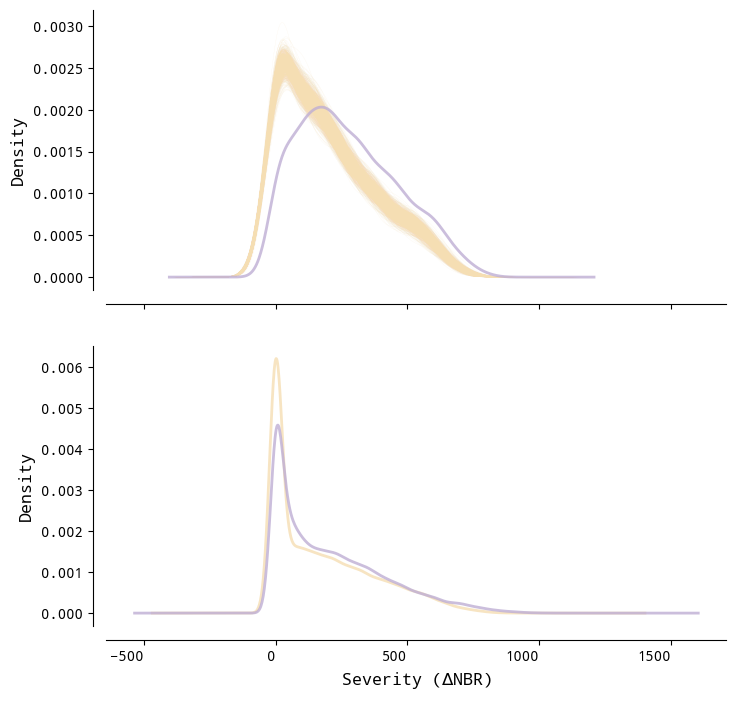

In [ ]:
# Plot distribution of benefits
fig, ax = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

sims_event = df[df.event_id == "CA3720111927220200905"]

for sim in df.sim.unique():
    sims_event[(sims_event.sim == sim)].sim_benefit.plot.density(
        ax=ax[0], color="wheat", alpha=0.5, linewidth=0.1
    )

treatments_dnbr[
    treatments_dnbr.Event_ID == "CA3720111927220200905"
].dnbr.plot.density(ax=ax[0], color="#beaed4", linewidth=2, alpha=0.8)

# sims_event.groupby("grid_id").sim_benefit.mean().plot.density(
#     ax=ax[0], color="orange", linewidth=2, alpha=0.5
# )

# Apply template
template_plots(ax[0], xlab="Severity ($\Delta$NBR)", ylab="Density")

# Plot the same, but for all the events
all_sims = (
    df.groupby(["grid_id"])
    .sim_benefit.min()
    .plot.density(ax=ax[1], color="wheat", linewidth=2, alpha=0.8)
)

# for sim in df.sim.unique():
#     all_sims[(all_sims.sim == sim)].sim_benefit.plot.density(
#         ax=ax[1], color="wheat", alpha=0.5, linewidth=0.1
#     )

treatments_dnbr[
    (treatments_dnbr.year > 2010) & (treatments_dnbr.year < 2021)
].dnbr.plot.density(ax=ax[1], color="#beaed4", linewidth=2, alpha=0.8)

# all_sims.groupby("grid_id").sim_benefit.median().plot.density(
#     ax=ax[1], color="orange", linewidth=2, alpha=0.5
# )

# Apply template
template_plots(ax[1], xlab="Severity ($\Delta$NBR)", ylab="Density")

# Save plot as PDF
plt.savefig(
    "../figs/benefits_fire_creek.pdf",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)

### Check that this is a good fit of $\Delta \text{NBR}$ for $PM_{2.5}$

In [ ]:
from prescribed.plot import get_best_poly_fit

# Remove outliers from smoke linked data
smoke_linked = smoke_linked[
    (smoke_linked.sum_severity <= smoke_linked.sum_severity.quantile(0.975))
    & (smoke_linked.sum_severity >= smoke_linked.sum_severity.quantile(0.025))
]

get_best_poly_fit(
    y=smoke_linked[["sum_contrib"]],
    X=smoke_linked[["sum_severity", "total_pixels", "total_days"]],
    degrees=range(1, 10),
)

{'degrees': range(1, 10),
 'rmses': [38968.01918144658,
  38855.25576425268,
  42455.39000671866,
  52498.528445898584,
  60284.46673012927,
  65188.90371827918,
  67983.45088023301,
  69825.16129452967,
  71267.4014130407],
 'best_degree': 2}